In [13]:
import pandas as pd
import os
import xarray as xr
xr.set_options(display_expand_attrs=True, display_width=1000, display_max_rows=1000)

import sys
sys.path.append(r"c:\Users\dias3\Desktop\FIRE-HACK\Notebooks\5Deployment\backend")

from utils import Model_Prediction
import importlib
importlib.reload(Model_Prediction)

<module 'utils.Model_Prediction' from 'c:\\Users\\dias3\\Desktop\\FIRE-HACK\\Notebooks\\5Deployment\\backend\\utils\\Model_Prediction.py'>

In [14]:
# inputs da interface

duration = 1

mins_since_fire_start = 0

start_time = pd.to_datetime("2020-10-15 14:10:00")
start_time = start_time.round('30min')
print(start_time)

2020-10-15 14:00:00


In [15]:
master_file = "Data/Master_Table.nc"
ds_master = None

# ------------------- Checar se Master_Table existe -------------------
if os.path.exists(master_file):
    with xr.open_dataset(master_file) as ds:
        ds_master = ds.load()  # Carrega em memória e fecha o arquivo

# ------------------- Verificar se já existem dados válidos para todas as durations -------------------
data_exists = False
cols_to_check = ['fuel_load', 'pct_3_8', 'pct_8p', 
                 'wv100_kh', 'FWI_12h', 'predictions', 'linear_pred']

if ds_master is not None:
    valid = True
    for dur in range(1, duration + 1):
        try:
            df_slice = ds_master.sel(
                s_time=start_time,
                duration_hours=dur,
                fstart=mins_since_fire_start
            ).to_dataframe().reset_index()

            # Se nenhuma coluna de interesse tiver valor válido, a duração não está pronta
            if not df_slice[cols_to_check].notna().any().any():
                valid = False
                break  # não precisa checar as próximas durations

        except KeyError:
            valid = False
            break

    data_exists = valid

# ------------------- Extrair ou calcular -------------------
if data_exists:
    print("Dados já existentes no Master_Table. Extraindo...")
    # Extrair todas as durations de 1 até duration
    model_inputs = ds_master.sel(
        s_time=start_time,
        duration_hours=slice(1, duration),
        fstart=mins_since_fire_start
    ).to_dataframe().reset_index()
else:
    print("Calculando novos dados e atualizando Master_Table...")
    # Chama a função do Model_Prediction.py
    Model_Prediction.calculate_and_append_master(start_time, duration, mins_since_fire_start)

    # Depois de atualizar o NetCDF, abrir a fatia recém-calculada
    with xr.open_dataset(master_file) as ds:
        ds_master = ds.load()
        model_inputs = ds_master.sel(
            s_time=start_time,
            duration_hours=slice(1, duration),
            fstart=mins_since_fire_start
        ).to_dataframe().reset_index()

# ------------------- Limpar model_inputs -------------------
# Remover linhas onde **todas essas colunas** são NaN
model_inputs = model_inputs.dropna(subset=cols_to_check, how='all')

print(model_inputs.head())


Calculando novos dados e atualizando Master_Table...
Existing FireData NetCDF found.
Missing times [Timestamp('2020-10-15 14:00:00'), Timestamp('2020-10-15 15:00:00')]
  Years:  [2020]
  Months: [10]
  Days:   [15]
  Hours:  [14, 15]


2025-12-10 19:20:59,896 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


Requesting: ERA5_SL_2020_10_15_1415.nc


2025-12-10 19:21:00,522 INFO Request ID is 7216d12f-1c33-437c-ac5e-d8bd9fc1b734
2025-12-10 19:21:00,610 INFO status has been updated to accepted
2025-12-10 19:21:14,280 INFO status has been updated to running
2025-12-10 19:21:21,950 INFO status has been updated to successful


23ab3b7e153f421aacc832eaeac2edc2.nc:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Requesting: ERA5_PL_2020_10_15_1415.nc


2025-12-10 19:21:22,940 INFO Request ID is 03335b66-267c-4cd8-88d1-0f24bc1f4337
2025-12-10 19:21:23,024 INFO status has been updated to accepted
2025-12-10 19:21:36,645 INFO status has been updated to running
2025-12-10 19:21:44,309 INFO status has been updated to successful


9bfb3603542e6cb0d97e50e670e1d237.nc:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

2025-12-10 19:21:45,254 INFO Request ID is 3a120f44-5098-4dd3-b6e1-c5f79f9e4f28


Requesting: ERA5_FWI_2020_10_15_1415.nc


2025-12-10 19:21:45,350 INFO status has been updated to accepted
2025-12-10 19:22:06,641 INFO status has been updated to successful


b4d52911b71dfbcb175a4e0dce37f429.nc:   0%|          | 0.00/35.5k [00:00<?, ?B/s]

Requesting: ERA5_Lan_2020_10_15_1415.nc


2025-12-10 19:22:07,753 INFO Request ID is b8cc5045-0596-4297-a991-23e7e0928a7f
2025-12-10 19:22:07,836 INFO status has been updated to accepted
2025-12-10 19:22:16,281 INFO status has been updated to running
2025-12-10 19:22:21,444 INFO status has been updated to successful


13dc9b3144052c780db670bff295c3b7.nc:   0%|          | 0.00/86.1k [00:00<?, ?B/s]

Loading datasets...
<xarray.Dataset> Size: 20kB
Dimensions:     (valid_time: 2, latitude: 29, longitude: 17)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 16B 2020-10-15T14:00:00 2020-10-15T15:00:00
  * latitude    (latitude) float64 232B 43.0 42.75 42.5 42.25 42.0 41.75 41.5 41.25 41.0 40.75 40.5 40.25 40.0 39.75 39.5 39.25 39.0 38.75 38.5 38.25 38.0 37.75 37.5 37.25 37.0 36.75 36.5 36.25 36.0
  * longitude   (longitude) float64 136B -10.0 -9.75 -9.5 -9.25 -9.0 -8.75 -8.5 -8.25 -8.0 -7.75 -7.5 -7.25 -7.0 -6.75 -6.5 -6.25 -6.0
    number      int64 8B ...
    expver      (valid_time) <U4 32B ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 4kB ...
    v10         (valid_time, latitude, longitude) float32 4kB ...
    t2m         (valid_time, latitude, longitude) float32 4kB ...
    d2m         (valid_time, latitude, longitude) float32 4kB ...
    cape        (valid_time, latitude, longitude) float32 4kB ...
Attributes:
    GRIB_centre:            

c:\Users\dias3\Desktop\FIRE-HACK\Notebooks\5Deployment\backend\utils\Model_Prediction.py:23: UserWarning: [19:22:24] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\gbm\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  model = pickle.load(f)


Master_Table atualizado: Data/Master_Table.nc


c:\Users\dias3\Desktop\FIRE-HACK\Notebooks\5Deployment\backend\utils\Model_Prediction.py:92: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'duration_hours' ('duration_hours',) The recommendation is to set join explicitly for this case.
  ds_combined = xr.concat([ds_master, ds_new], dim='s_time')
c:\Users\dias3\Desktop\FIRE-HACK\Notebooks\5Deployment\backend\utils\Model_Prediction.py:96: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2017-10-15T11:00:00'. Serializing with units 'hours since 2017-10-15T11:00:00' instead. Set encoding['dtype'] to floating point dtype to serialize with units 'days since 2017-10-15T11:00:00'. Set encoding['units'] to 'hours since 2017-10-15T11:00:00' to silence this warning .


KeyError: ['predictions']

In [ ]:
# Começar com todo o model_inputs
df_slice = model_inputs.copy()

In [ ]:
'''import numpy as np
from scipy.ndimage import gaussian_filter

# Criar uma coluna para o valor suavizado
df_slice['linear_pred_smoothed'] = np.nan

# Iterar por cada duration individualmente
for duration in df_slice['duration_hours'].unique():
    
    # Subset para o duration atual
    df_sub = df_slice[df_slice['duration_hours'] == duration].copy()
    
    lat_vals = np.sort(df_sub['latitude'].unique())
    lon_vals = np.sort(df_sub['longitude'].unique())
    
    grid = np.full((len(lat_vals), len(lon_vals)), np.nan)
    mask = np.zeros_like(grid, dtype=bool)
    
    lat_idx = {lat:i for i, lat in enumerate(lat_vals)}
    lon_idx = {lon:i for i, lon in enumerate(lon_vals)}
    
    # Preencher grid e máscara
    for _, row in df_sub.iterrows():
        i = lat_idx[row['latitude']]
        j = lon_idx[row['longitude']]
        if not np.isnan(row['linear_pred']):
            grid[i,j] = row['linear_pred']
            mask[i,j] = True
    
    # Gaussian smoothing
    grid_filled = np.where(mask, grid, 0.0)
    weights = mask.astype(float)
    
    sigma = 1.5  # controla suavização
    grid_smooth = gaussian_filter(grid_filled, sigma=sigma)
    weights_smooth = gaussian_filter(weights, sigma=sigma)
    
    # Evitar divisão por zero usando um epsilon pequeno
    eps = 1e-10
    smoothed = np.where(mask, grid_smooth / (weights_smooth + eps), np.nan)
    
    # Mapear de volta para o DataFrame
    df_slice.loc[df_slice['duration_hours'] == duration, 'linear_pred_smoothed'] = [
        smoothed[lat_idx[row['latitude']], lon_idx[row['longitude']]]
        for _, row in df_sub.iterrows()
    ]

# df_slice agora contém a coluna linear_pred_smoothed para todos os durations
print(df_slice.head())
'''

"import numpy as np\nfrom scipy.ndimage import gaussian_filter\n\n# Criar uma coluna para o valor suavizado\ndf_slice['linear_pred_smoothed'] = np.nan\n\n# Iterar por cada duration individualmente\nfor duration in df_slice['duration_hours'].unique():\n\n    # Subset para o duration atual\n    df_sub = df_slice[df_slice['duration_hours'] == duration].copy()\n\n    lat_vals = np.sort(df_sub['latitude'].unique())\n    lon_vals = np.sort(df_sub['longitude'].unique())\n\n    grid = np.full((len(lat_vals), len(lon_vals)), np.nan)\n    mask = np.zeros_like(grid, dtype=bool)\n\n    lat_idx = {lat:i for i, lat in enumerate(lat_vals)}\n    lon_idx = {lon:i for i, lon in enumerate(lon_vals)}\n\n    # Preencher grid e máscara\n    for _, row in df_sub.iterrows():\n        i = lat_idx[row['latitude']]\n        j = lon_idx[row['longitude']]\n        if not np.isnan(row['linear_pred']):\n            grid[i,j] = row['linear_pred']\n            mask[i,j] = True\n\n    # Gaussian smoothing\n    grid_fil

In [ ]:
df_slice['linear_pred_smoothed'] = df_slice['linear_pred']

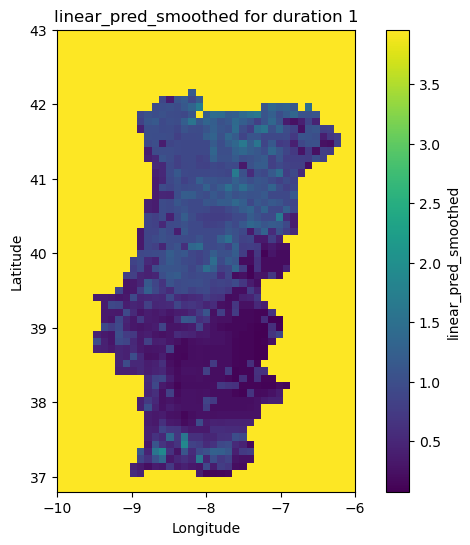

In [ ]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# df_slice já contém 'linear_pred_smoothed', 'latitude', 'longitude', 'duration_hours'

# ------------------- Determinar escala global -------------------
vmin = df_slice['linear_pred_smoothed'].min()
vmax = df_slice['linear_pred_smoothed'].max()

for duration in df_slice['duration_hours'].unique():
    # Filtrar pelo duration atual
    df = df_slice[df_slice['duration_hours'] == duration]

    # Ordenar latitudes e longitudes
    lat_vals = np.sort(df['latitude'].unique())
    lon_vals = np.sort(df['longitude'].unique())

    # Criar matriz 2D para linear_pred
    data_grid = np.full((len(lat_vals), len(lon_vals)), np.nan)

    # Preencher a matriz
    for i, lat in enumerate(lat_vals):
        for j, lon in enumerate(lon_vals):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)]['linear_pred_smoothed']
            if not val.empty:
                data_grid[i, j] = val.values[0]

    # Criar transform para raster (assumindo grade regular)
    pixel_size_lat = (lat_vals.max() - lat_vals.min()) / (len(lat_vals)-1)
    pixel_size_lon = (lon_vals.max() - lon_vals.min()) / (len(lon_vals)-1)
    transform = from_origin(lon_vals.min()-pixel_size_lon/2, 
                            lat_vals.max()+pixel_size_lat/2, 
                            pixel_size_lon, 
                            pixel_size_lat)

    # Inverter a matriz verticalmente para o TIFF
    data_grid_to_save = np.flipud(data_grid)

    # Salvar TIFF
    output_filename = rf'Data\Output\ros_linear_pred_duration_{duration}.tif'
    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=data_grid_to_save.shape[0],
        width=data_grid_to_save.shape[1],
        count=1,
        dtype=data_grid_to_save.dtype,
        crs='EPSG:4326',  # WGS84
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(data_grid_to_save, 1)

    # Plotar com mesma escala para todos os durations
    plt.figure(figsize=(8,6))
    plt.imshow(data_grid, origin='lower',
               extent=(lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()),
               vmin=vmin, vmax=vmax, cmap='viridis')  # mesma escala
    plt.colorbar(label='linear_pred_smoothed')
    plt.title(f'linear_pred_smoothed for duration {duration}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


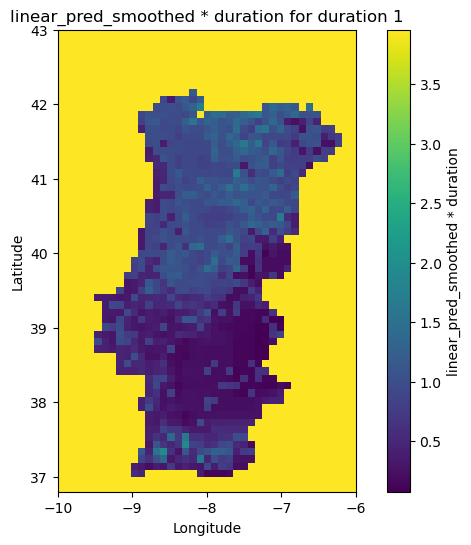

In [ ]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

# df_slice já contém 'linear_pred_smoothed', 'latitude', 'longitude', 'duration_hours'

# ------------------- Determinar escala global -------------------
# Escala global considerando linear_pred_smoothed * duration
vmin = (df_slice['linear_pred_smoothed'] * df_slice['duration_hours']).min()
vmax = (df_slice['linear_pred_smoothed'] * df_slice['duration_hours']).max()

for duration in df_slice['duration_hours'].unique():
    # Filtrar pelo duration atual
    df = df_slice[df_slice['duration_hours'] == duration]

    # Ordenar latitudes e longitudes
    lat_vals = np.sort(df['latitude'].unique())
    lon_vals = np.sort(df['longitude'].unique())

    # Criar matriz 2D para linear_pred
    data_grid = np.full((len(lat_vals), len(lon_vals)), np.nan)

    # Preencher a matriz
    for i, lat in enumerate(lat_vals):
        for j, lon in enumerate(lon_vals):
            val = df[(df['latitude'] == lat) & (df['longitude'] == lon)]['linear_pred_smoothed']
            if not val.empty:
                data_grid[i, j] = val.values[0] * duration  # multiplicar pelo duration

    # Criar transform para raster (assumindo grade regular)
    pixel_size_lat = (lat_vals.max() - lat_vals.min()) / (len(lat_vals)-1)
    pixel_size_lon = (lon_vals.max() - lon_vals.min()) / (len(lon_vals)-1)
    transform = from_origin(lon_vals.min()-pixel_size_lon/2, 
                            lat_vals.max()+pixel_size_lat/2, 
                            pixel_size_lon, 
                            pixel_size_lat)

    # Inverter a matriz verticalmente para o TIFF
    data_grid_to_save = np.flipud(data_grid)

    # Salvar TIFF
    output_filename = rf'Data\Output\ros_linear_pred_duration_{duration}.tif'
    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=data_grid_to_save.shape[0],
        width=data_grid_to_save.shape[1],
        count=1,
        dtype=data_grid_to_save.dtype,
        crs='EPSG:4326',  # WGS84
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(data_grid_to_save, 1)

    # Plotar com mesma escala global
    plt.figure(figsize=(8,6))
    plt.imshow(data_grid, origin='lower',
               extent=(lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()),
               vmin=vmin, vmax=vmax, cmap='viridis')
    plt.colorbar(label='linear_pred_smoothed * duration')
    plt.title(f'linear_pred_smoothed * duration for duration {duration}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()


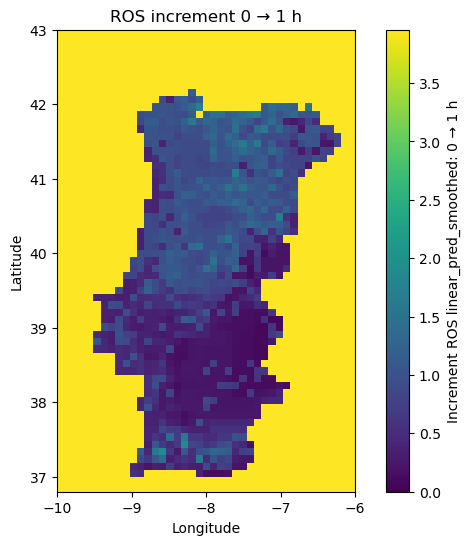

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# df_slice contém: latitude, longitude, duration_hours, linear_pred_smoothed

# Determinar o número máximo de horas
max_duration = int(df_slice['duration_hours'].max())

# Preparar lat/lon
lat_vals = np.sort(df_slice['latitude'].unique())
lon_vals = np.sort(df_slice['longitude'].unique())

# Construir dicionário para fácil acesso: {(lat, lon, duration): value}
value_dict = {
    (row['latitude'], row['longitude'], row['duration_hours']): row['linear_pred_smoothed']
    for _, row in df_slice.iterrows()
}

# Gerar plots de incrementos 0-1, 1-2, 2-3, ..., max_duration-1 → max_duration
for d in range(1, max_duration+1):
    data_grid = np.full((len(lat_vals), len(lon_vals)), np.nan)

    for i, lat in enumerate(lat_vals):
        for j, lon in enumerate(lon_vals):
            curr = value_dict.get((lat, lon, d), np.nan)
            prev = value_dict.get((lat, lon, d-1), 0.0) if d > 1 else 0.0
            data_grid[i,j] = curr * d - prev * (d-1)  # incremento da hora d

    # Escala global para todos os plots
    vmin = 0
    vmax = np.nanmax([value_dict.get((lat, lon, dur), 0.0) * dur for lat in lat_vals
                     for lon in lon_vals for dur in range(1, max_duration+1)])

    plt.figure(figsize=(8,6))
    plt.imshow(data_grid, origin='lower',
               extent=(lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()),
               vmin=vmin, vmax=vmax, cmap='viridis')
    plt.colorbar(label=f'Increment ROS linear_pred_smoothed: {d-1} → {d} h')
    plt.title(f'ROS increment {d-1} → {d} h')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
